In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import awkward1 as ak

from coffea import processor, hist
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from coffea.analysis_tools import Weights

import numpy as np

from yahist import Hist1D, Hist2D


In [3]:
from Tools.objects import *
from Tools.basic_objects import *
from Tools.cutflow import *
from Tools.config_helpers import *
from Tools.triggers import *
year = 2018

lumis = {2016: 36., 2017: 41.5, 2018: 60.}

In [4]:
class btagAnalyzer(processor.ProcessorABC):
    def __init__(self):
                # we can use a large number of bins and rebin later
        dataset_axis        = hist.Cat("dataset",   "Primary dataset")
        pt_axis             = hist.Bin("pt",        r"$p_{T}$ (GeV)", 100, 0, 1000)
        eta_axis            = hist.Bin("eta",       r"$\eta$", 10, -2.5, 2.5)

        self._accumulator = processor.dict_accumulator({
            
            "b_all" :             hist.Hist("Counts", pt_axis, eta_axis),
            "b_pass_deepJet" :    hist.Hist("Counts", pt_axis, eta_axis),
            "b_pass_deepCSV" :    hist.Hist("Counts", pt_axis, eta_axis),
            "c_all" :             hist.Hist("Counts", pt_axis, eta_axis),
            "c_pass_deepJet" :    hist.Hist("Counts", pt_axis, eta_axis),
            "c_pass_deepCSV" :    hist.Hist("Counts", pt_axis, eta_axis),
            "light_all":          hist.Hist("Counts", pt_axis, eta_axis),
            "light_pass_deepJet": hist.Hist("Counts", pt_axis, eta_axis),
            "light_pass_deepCSV": hist.Hist("Counts", pt_axis, eta_axis),
            
            'skimmedEvents':    processor.defaultdict_accumulator(int),
            'totalEvents':      processor.defaultdict_accumulator(int),
        })

    @property
    def accumulator(self):
        return self._accumulator

    # we will receive a NanoEvents instead of a coffea DataFrame
    def process(self, events):
        
        output = self.accumulator.identity()
        
        presel = ak.num(events.Jet)>2
        
        ev = events[presel]
        dataset = ev.metadata['dataset']
        

        
        output['totalEvents']['all'] += len(events)
        output['skimmedEvents']['all'] += len(ev)
        
        ## Muons
        muon     = Collections(ev, "Muon", "tightTTH").get()
        vetomuon = Collections(ev, "Muon", "vetoTTH").get()
        dimuon   = choose(muon, 2)
        
        
        ## Electrons
        electron     = Collections(ev, "Electron", "tightTTH").get()
        vetoelectron = Collections(ev, "Electron", "vetoTTH").get()
        dielectron   = choose(electron, 2)
        
        
        ## Merge electrons and muons - this should work better now in ak1
        lepton   = ak.concatenate([muon, electron], axis=1)
        dilepton = cross(muon, electron)
        
        
        ## Jets
        jet       = getJets(ev, minPt=25, maxEta=2.5)
        jet       = jet[(jet.pt>25) & (jet.jetId>1)]
        jet       = jet[~match(jet, muon, deltaRCut=0.4)] # remove jets that overlap with muons
        jet       = jet[~match(jet, electron, deltaRCut=0.4)] # remove jets that overlap with electrons
        
        ## true bottoms
        bottom = jet[abs(jet.hadronFlavour)==5]
        bottom_deepJet = getBTagsDeepFlavB(bottom, year=year)
        bottom_deepCSV = getBTagsDeepB(bottom, year=year)
        
        ## true charms
        charm = jet[abs(jet.hadronFlavour)==4]
        charm_deepJet = getBTagsDeepFlavB(charm, year=year)
        charm_deepCSV = getBTagsDeepB(charm, year=year)
        
        ## true lights
        light = jet[((abs(jet.hadronFlavour)<4) | (abs(jet.hadronFlavour)>5))]
        light_deepJet = getBTagsDeepFlavB(light, year=year)
        light_deepCSV = getBTagsDeepB(light, year=year)
        
        ## event selectors
        filters   = getFilters(ev, year=year, dataset=dataset)
        
        dilep     = ((ak.num(electron) + ak.num(muon))==2)
        lepveto   = ((ak.num(vetoelectron) + ak.num(vetomuon))==2)
        
        selection = (filters & dilep & lepveto)
        
        # first, make a few super inclusive plots
        output['b_all'].fill(pt=ak.flatten(bottom.pt), eta=ak.flatten(bottom.eta))
        output['b_pass_deepJet'].fill(pt=ak.flatten(bottom_deepJet.pt), eta=ak.flatten(bottom_deepJet.eta))
        output['b_pass_deepCSV'].fill(pt=ak.flatten(bottom_deepCSV.pt), eta=ak.flatten(bottom_deepCSV.eta))
        
        output['c_all'].fill(pt=ak.flatten(charm.pt), eta=ak.flatten(charm.eta))
        output['c_pass_deepJet'].fill(pt=ak.flatten(charm_deepJet.pt), eta=ak.flatten(charm_deepJet.eta))
        output['c_pass_deepCSV'].fill(pt=ak.flatten(charm_deepCSV.pt), eta=ak.flatten(charm_deepCSV.eta))
        
        output['light_all'].fill(pt=ak.flatten(light.pt), eta=ak.flatten(light.eta))
        output['light_pass_deepJet'].fill(pt=ak.flatten(light_deepJet.pt), eta=ak.flatten(light_deepJet.eta))
        output['light_pass_deepCSV'].fill(pt=ak.flatten(light_deepCSV.pt), eta=ak.flatten(light_deepCSV.eta))
        
        return output

    def postprocess(self, accumulator):
        return accumulator

In [5]:
# load the basic filesets and choose what samples we actually want to load

from Tools.samples import * # fileset_2018 #, fileset_2018_small

fileset_2018.keys()

dict_keys(['tW_scattering', 'topW_v2', 'TTXnoW', 'TTW', 'TTH', 'TTZ', 'TTTT', 'ttbar', 'ttbar1l', 'ttbar2l', 'ttbar1l_MG', 'wjets', 'diboson', 'DY', 'MuonEG'])

In [6]:



'''
fileset = {
    'tW_scattering': glob.glob("/hadoop/cms/store/user/dspitzba/tW_scattering/tW_scattering/nanoAOD/*.root"),
    'topW_v2': glob.glob("/hadoop/cms/store/user/dspitzba/ProjectMetis/TTWJetsToLNuEWK_5f_NLO_RunIIAutumn18_NANO_v2/*.root"),
    
}
'''


fileset = {
    #'tW_scattering': fileset_2018['tW_scattering'],
    #'topW_v2': fileset_2018['topW_v2'],
    'ttbar': fileset_2018['ttbar2l'], # dilepton ttbar should be enough for this study.
    #'MuonEG': fileset_2018['MuonEG'],
}


exe_args = {
    'workers': 16,
    'function_args': {'flatten': False},
    "schema": NanoAODSchema,
}
exe = processor.futures_executor

output = processor.run_uproot_job(
    fileset,
    "Events",
    btagAnalyzer(),
    exe,
    exe_args,
    chunksize=250000,
)

Preprocessing:   0%|          | 0/61 [00:00<?, ?file/s]

Processing:   0%|          | 0/200 [00:00<?, ?chunk/s]

In [7]:
pt_bins = hist.Bin('pt', r'$p_{T} \ (GeV)$', np.array([20,30,50,70,100,140,200,300,600]))
eta_bins = hist.Bin('eta', r'$\eta$', np.array([-2.5,2.5]))

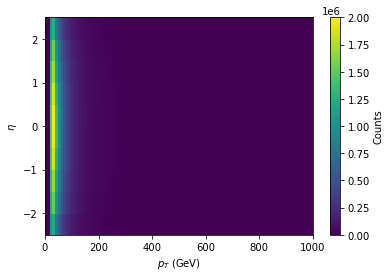

In [8]:
ax = hist.plot2d(output['light_all'], xaxis='pt')

In [9]:
h1 = Hist2D.from_bincounts(
    output['b_pass_deepJet'].sum().values()[()].T,
    (output['b_pass_deepJet'].axis('pt').edges(), output['b_pass_deepJet'].axis('eta').edges())
)

h2 = Hist2D.from_bincounts(
    output['b_all'].sum().values()[()].T,
    (output['b_all'].axis('pt').edges(), output['b_all'].axis('eta').edges())
)

In [10]:
h1.divide(h2)

[[  nan ±  nan     nan ±  nan    0.66 ± 0.00    0.71 ± 0.00
   0.73 ± 0.00    0.74 ± 0.00    0.75 ± 0.00    0.75 ± 0.00
   0.76 ± 0.00    0.76 ± 0.00    0.76 ± 0.00    0.76 ± 0.00
   0.77 ± 0.00    0.77 ± 0.01    0.77 ± 0.01    0.77 ± 0.01
   0.77 ± 0.01    0.78 ± 0.01    0.77 ± 0.01    0.77 ± 0.01
   0.77 ± 0.01    0.78 ± 0.02    0.77 ± 0.02    0.76 ± 0.02
   0.77 ± 0.02    0.76 ± 0.03    0.76 ± 0.03    0.75 ± 0.03
   0.75 ± 0.04    0.76 ± 0.04    0.77 ± 0.05    0.74 ± 0.05
   0.69 ± 0.05    0.75 ± 0.06    0.78 ± 0.07    0.72 ± 0.07
   0.73 ± 0.08    0.76 ± 0.08    0.72 ± 0.09    0.69 ± 0.10
   0.71 ± 0.09    0.78 ± 0.12    0.71 ± 0.12    0.69 ± 0.12
   0.79 ± 0.16    0.65 ± 0.15    0.69 ± 0.15    0.74 ± 0.18
   0.76 ± 0.17    0.62 ± 0.16    0.80 ± 0.20    0.85 ± 0.28
   0.56 ± 0.31    0.78 ± 0.25    0.87 ± 0.33    0.70 ± 0.34
   0.67 ± 0.30    0.80 ± 0.38    0.75 ± 0.41    0.60 ± 0.44
   0.78 ± 0.39    0.67 ± 0.43    0.60 ± 0.44    0.62 ± 0.36
   0.70 ± 0.34    1.00 ± 1.00    1.00 ± 0.50    0.00 ± 0.00
   0.67 ± 0.61    1.00 ± 1.41    0.00 ± 0.00     nan ±  nan
    nan ±  nan     nan ±  nan    1.00 ± 1.41     nan ±  nan
    nan ±  nan     nan ±  nan    1.00 ± 1.41    1.00 ± 1.41
   1.00 ± 1.41     nan ±  nan     nan ±  nan     nan ±  nan
    nan ±  nan     nan ±  nan     nan ±  nan     nan ±  nan
    nan ±  nan     nan ±  nan     nan ±  nan     nan ±  nan
    nan ±  nan     nan ±  nan     nan ±  nan     nan ±  nan
    nan ±  nan     nan ±  nan     nan ±  nan    1.00 ± 1.41]
 [  nan ±  nan     nan ±  nan    0.70 ± 0.00    0.74 ± 0.00
   0.76 ± 0.00    0.78 ± 0.00    0.79 ± 0.00    0.79 ± 0.00
   0.80 ± 0.00    0.80 ± 0.00    0.80 ± 0.00    0.80 ± 0.00
   0.81 ± 0.00    0.81 ± 0.00    0.81 ± 0.00    0.81 ± 0.00
   0.81 ± 0.01    0.81 ± 0.01    0.82 ± 0.01    0.81 ± 0.01
   0.82 ± 0.01    0.81 ± 0.01    0.81 ± 0.01    0.81 ± 0.01
   0.82 ± 0.01    0.82 ± 0.02    0.81 ± 0.02    0.81 ± 0.02
   0.80 ± 0.02    0.81 ± 0.02    0.80 ± 0.02    0.81 ± 0.03
   0.82 ± 0.03    0.81 ± 0.03    0.80 ± 0.03    0.81 ± 0.04
   0.79 ± 0.04    0.82 ± 0.04    0.81 ± 0.05    0.81 ± 0.05
   0.79 ± 0.05    0.78 ± 0.06    0.84 ± 0.06    0.85 ± 0.06
   0.76 ± 0.07    0.77 ± 0.07    0.85 ± 0.08    0.79 ± 0.08
   0.78 ± 0.09    0.81 ± 0.09    0.79 ± 0.09    0.85 ± 0.11
   0.75 ± 0.11    0.80 ± 0.11    0.82 ± 0.12    0.79 ± 0.13
   0.86 ± 0.13    0.84 ± 0.14    0.81 ± 0.14    0.83 ± 0.15
   0.83 ± 0.17    0.80 ± 0.17    0.70 ± 0.17    0.75 ± 0.18
   0.77 ± 0.20    0.85 ± 0.22    0.74 ± 0.22    0.78 ± 0.20
   0.79 ± 0.22    0.89 ± 0.30    0.65 ± 0.19    0.87 ± 0.27
   1.00 ± 0.35    0.80 ± 0.31    0.94 ± 0.33    0.78 ± 0.39
   0.57 ± 0.36    0.38 ± 0.25    0.83 ± 0.50    0.88 ± 0.45
   0.83 ± 0.50    0.88 ± 0.45    0.75 ± 0.57    0.62 ± 0.36
   0.67 ± 0.61    0.50 ± 0.43    0.50 ± 0.31    1.00 ± 1.41
    nan ±  nan    0.00 ± 0.00     nan ±  nan    0.60 ± 0.44
   1.00 ± 0.63    1.00 ± 1.41    1.00 ± 1.41    0.00 ± 0.00
   1.00 ± 1.41    0.67 ± 0.61    0.67 ± 0.61     nan ±  nan]
 [  nan ±  nan     nan ±  nan    0.73 ± 0.00    0.76 ± 0.00
   0.78 ± 0.00    0.80 ± 0.00    0.80 ± 0.00    0.81 ± 0.00
   0.82 ± 0.00    0.82 ± 0.00    0.82 ± 0.00    0.82 ± 0.00
   0.82 ± 0.00    0.82 ± 0.00    0.82 ± 0.00    0.83 ± 0.00
   0.83 ± 0.00    0.83 ± 0.00    0.83 ± 0.01    0.83 ± 0.01
   0.83 ± 0.01    0.83 ± 0.01    0.82 ± 0.01    0.82 ± 0.01
   0.82 ± 0.01    0.82 ± 0.01    0.83 ± 0.01    0.83 ± 0.01
   0.83 ± 0.01    0.82 ± 0.02    0.84 ± 0.02    0.82 ± 0.02
   0.81 ± 0.02    0.83 ± 0.02    0.82 ± 0.02    0.82 ± 0.03
   0.81 ± 0.03    0.81 ± 0.03    0.81 ± 0.03    0.82 ± 0.03
   0.80 ± 0.03    0.81 ± 0.04    0.82 ± 0.04    0.83 ± 0.04
   0.82 ± 0.04    0.82 ± 0.05    0.78 ± 0.05    0.82 ± 0.05
   0.85 ± 0.05    0.81 ± 0.05    0.84 ± 0.06    0.83 ± 0.06
   0.84 ± 0.07    0.81 ± 0.07    0.81 ± 0.07    0.81 ± 0.07
   0.88 ± 0.08    0.81 ± 0.08    0.83 ± 0.09    0.86 ± 0.09
   0.79 ± 0.09    0.84 ± 0.09    0.78 ± 0.10    0.85 ± 0.10
   0.82 ± 0.11    0.83 ± 0.11    0.78 

In [11]:
pt_bins = hist.Bin('pt', r'$p_{T} \ (GeV)$', np.array([20,30,50,70,100,140,200,300,600]))

def getNiceHist(output, name, rebin, axis):
    tmp = output[name].copy().project(axis).rebin(axis, rebin)
    ya_tmp = Hist1D.from_bincounts(
        tmp.sum().values(overflow='over')[()],
        errors = np.sqrt(tmp.sum().values(overflow='over', sumw2=True)[()][1]),
        bins = tmp.axis(axis).edges(overflow='over')
    )
    return ya_tmp

In [12]:
b_all = getNiceHist(output, 'b_all', pt_bins, 'pt')
b_pass_deepCSV = getNiceHist(output, 'b_pass_deepCSV', pt_bins, 'pt')
b_pass_deepJet = getNiceHist(output, 'b_pass_deepJet', pt_bins, 'pt')

c_all = getNiceHist(output, 'c_all', pt_bins, 'pt')
c_pass_deepCSV = getNiceHist(output, 'c_pass_deepCSV', pt_bins, 'pt')
c_pass_deepJet = getNiceHist(output, 'c_pass_deepJet', pt_bins, 'pt')

light_all = getNiceHist(output, 'light_all', pt_bins, 'pt')
light_pass_deepCSV = getNiceHist(output, 'light_pass_deepCSV', pt_bins, 'pt')
light_pass_deepJet = getNiceHist(output, 'light_pass_deepJet', pt_bins, 'pt')

Text(0.1, 0.995, '$\\bf{CMS}$ Simulation')

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.


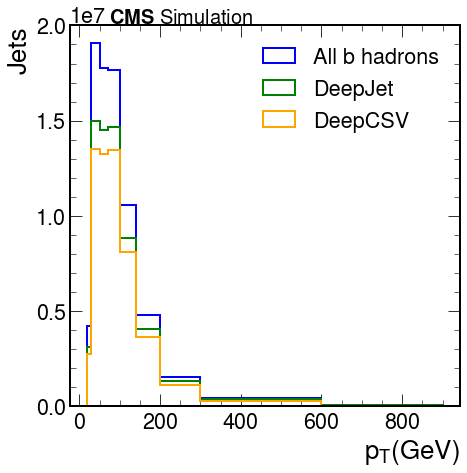

In [13]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import mplhep as hep

plt.style.use(hep.style.CMS)  # or ATLAS/LHCb

fig, ax = plt.subplots(1,1,figsize=(7,7))

b_all.plot(color="blue", histtype="step", linewidth=2, label='All b hadrons')
b_pass_deepJet.plot(color="green", histtype="step", linewidth=2, label='DeepJet')
b_pass_deepCSV.plot(color="orange", histtype="step", linewidth=2, label='DeepCSV')

ax.set_ylabel('Jets')
ax.set_xlabel(r'$p_{T} (GeV)$')

#ax.set_ylim(0.05,1.05)

fig.text(0.10, 0.995, '$\\bf{CMS}$ Simulation', fontsize=20,  horizontalalignment='left', verticalalignment='bottom', transform=ax.transAxes )



Text(0.8, 0.995, '13 TeV')

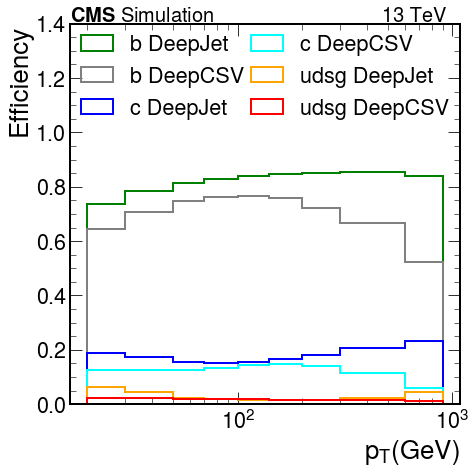

In [14]:
fig, ax = plt.subplots(1,1,figsize=(7,7))

b_eff_deepJet = b_pass_deepJet.divide(b_all, binomial=True)
b_eff_deepCSV = b_pass_deepCSV.divide(b_all, binomial=True)

c_eff_deepJet = c_pass_deepJet.divide(c_all, binomial=True)
c_eff_deepCSV = c_pass_deepCSV.divide(c_all, binomial=True)

light_eff_deepJet = light_pass_deepJet.divide(light_all, binomial=True)
light_eff_deepCSV = light_pass_deepCSV.divide(light_all, binomial=True)


b_eff_deepJet.plot(color="green", histtype="step", linewidth=2, label='b DeepJet')
b_eff_deepCSV.plot(color="gray", histtype="step", linewidth=2, label='b DeepCSV')

c_eff_deepJet.plot(color="blue", histtype="step", linewidth=2, label='c DeepJet')
c_eff_deepCSV.plot(color="cyan", histtype="step", linewidth=2, label='c DeepCSV')

light_eff_deepJet.plot(color="orange", histtype="step", linewidth=2, label='udsg DeepJet')
light_eff_deepCSV.plot(color="red", histtype="step", linewidth=2, label='udsg DeepCSV')

ax.set_ylabel('Efficiency')
ax.set_xlabel(r'$p_{T} (GeV)$')

ax.set_ylim(0.00,1.40)

plt.xscale('log')

plt.legend(
    #bbox_to_anchor=(0., 1.02, 1., .102),
    loc='upper left',
    ncol=2,
    mode="expand",
    borderaxespad=0.0
)

fig.text(0.0, 0.995, '$\\bf{CMS}$ Simulation', fontsize=20,  horizontalalignment='left', verticalalignment='bottom', transform=ax.transAxes )
fig.text(0.8, 0.995, '13 TeV', fontsize=20,  horizontalalignment='left', verticalalignment='bottom', transform=ax.transAxes )



In [16]:
# I can export the measurement from yahist

b_eff_deepJet.to_json()

'{"_counts": [0.7376442262012629, 0.7857133899293974, 0.8155672128924673, 0.8302726725590459, 0.8394370109068536, 0.8458411935269683, 0.8489540733364138, 0.8535575940342952, 0.8405694202847102], "_edges": [20.0, 30.0, 50.0, 70.0, 100.0, 140.0, 200.0, 300.0, 600.0, 900.0], "_errors": [0.00021479576677363443, 9.402149272763616e-05, 9.206291588520488e-05, 8.931976104759043e-05, 0.00011312146709130388, 0.00016531972916838944, 0.0002894200642614142, 0.0005629123859409724, 0.002198937174614002], "_errors_up": [0.00021473914320369047, 9.400649685187279e-05, 9.204514230221061e-05, 8.930106993543241e-05, 0.0001130892538503403, 0.00016524728812972178, 0.00028919237783930907, 0.000562018131691544, 0.0021867484537508863], "_errors_down": [0.0002148523903435784, 9.403648860339953e-05, 9.208068946819914e-05, 8.933845215974845e-05, 0.00011315368033226747, 0.0001653921702070571, 0.00028964775068351933, 0.0005638066401904007, 0.0022111258954771174], "_metadata": {}}'

In [17]:
# lookup is easy, but only works for np arrays (so far)

b_eff_deepJet.lookup(30)

0.7857133899293974

In [91]:
b_eff_deepJet.to_json(os.path.expandvars("$TWHOME/Tools/data/btag/Autumn18_b_eff_deepJet.json"))
c_eff_deepJet.to_json(os.path.expandvars("$TWHOME/Tools/data/btag/Autumn18_c_eff_deepJet.json"))
light_eff_deepJet.to_json(os.path.expandvars("$TWHOME/Tools/data/btag/Autumn18_light_eff_deepJet.json"))

# Development of SF calculation

The coffea tools aren't so helpful. We need to have Method 1a implemented.


In [9]:
from coffea.lookup_tools import extractor
from coffea.btag_tools import BTagScaleFactor

# deal with the SFs
SF_file = os.path.expandvars('$TWHOME/Tools/data/btag/DeepJet_102XSF_V2.csv')
btag_sf = BTagScaleFactor(SF_file, "medium", keep_df=True)

# and load the efficiencies
effs = {
    'b': Hist1D.from_json(os.path.expandvars("$TWHOME/Tools/data/btag/Autumn18_b_eff_deepJet.json")),
    'c': Hist1D.from_json(os.path.expandvars("$TWHOME/Tools/data/btag/Autumn18_c_eff_deepJet.json")),
    'light': Hist1D.from_json(os.path.expandvars("$TWHOME/Tools/data/btag/Autumn18_light_eff_deepJet.json")),
}


In [10]:
df = btag_sf.df
df

OperatingPoint  \
sysType           jetFlavor etaBin      ptBin       discrBin                   
central           0         (-2.5, 2.5) (20, 1000)  (0, 1)                 1   
                  1         (-2.5, 2.5) (20, 1000)  (0, 1)                 1   
                  2         (0.0, 2.5)  (20, 1000)  (0, 1)                 1   
down              0         (-2.5, 2.5) (20, 30)    (0, 1)                 1   
                                        (30, 50)    (0, 1)                 1   
                                        (50, 70)    (0, 1)                 1   
                                        (70, 100)   (0, 1)                 1   
                                        (100, 140)  (0, 1)                 1   
                                        (140, 200)  (0, 1)                 1   
                                        (200, 300)  (0, 1)                 1   
                                        (300, 600)  (0, 1)                 1   
                                        (600, 1000) (0, 1)                 1   
                  1         (-2.5, 2.5) (20, 30)    (0, 1)                 1   
                                        (30, 50)    (0, 1)                 1   
                                        (50, 70)    (0, 1)                 1   
                                        (70, 100)   (0, 1)                 1   
                                        (100, 140)  (0, 1)                 1   
                                        (140, 200)  (0, 1)                 1   
                                        (200, 300)  (0, 1)                 1   
                                        (300, 600)  (0, 1)                 1   
                                        (600, 1000) (0, 1)                 1   
                  2         (0.0, 2.5)  (20, 1000)  (0, 1)                 1   
down_correlated   2         (0.0, 2.5)  (20, 1000)  (0, 1)                 1   
down_uncorrelated 2         (0.0, 2.5)  (20, 1000)  (0, 1)                 1   
up                0         (-2.5, 2.5) (20, 30)    (0, 1)                 1   
                                        (30, 50)    (0, 1)                 1   
                                        (50, 70)    (0, 1)                 1   
                                        (70, 100)   (0, 1)                 1   
                                        (100, 140)  (0, 1)                 1   
                                        (140, 200)  (0, 1)                 1   
                                        (200, 300)  (0, 1)                 1   
                                        (300, 600)  (0, 1)                 1   
                                        (600, 1000) (0, 1)                 1   
                  1         (-2.5, 2.5) (20, 30)    (0, 1)                 1   
                                        (30, 50)    (0, 1)                 1   
                                        (50, 70)    (0, 1)                 1   
                                        (70, 100)   (0, 1)                 1   
                                        (100, 140)  (0, 1)                 1   
                                        (140, 200)  (0, 1)                 1   
                                        (200, 300)  (0, 1)                 1   
                                        (300, 600)  (0, 1)                 1   
                                        (600, 1000) (0, 1)                 1   
                  2         (0.0, 2.5)  (20, 1000)  (0, 1)                 1   
up_correlated     2         (0.0, 2.5)  (20, 1000)  (0, 1)                 1   
up_uncorrelated   2         (0.0, 2.5)  (20, 1000)  (0, 1)                 1   

                                                             measurementType  \
sysType           jetFlavor etaBin      ptBin       discrBin                   
central           0         (-2.5, 2.5) (20, 1000)  (0, 1)              comb   
                  1         (-2.5, 2.5) (20, 1000)  (0, 1)   

In [11]:
# load some jets
from Tools.basic_objects import *

from coffea.nanoevents import NanoEventsFactory, NanoAODSchema

# the below command will change to .from_root in coffea v0.7.0
events = NanoEventsFactory.from_root('/hadoop/cms/store/user/dspitzba/tW_scattering/tW_scattering/nanoAOD/tW_scattering_nanoAOD_123.root', schemaclass=NanoAODSchema).events()

jet       = getJets(events, minPt=25, maxEta=2.5)

# should have those seperately
tagged = getBTagsDeepFlavB(jet, year=2018, invert=False)
untagged = getBTagsDeepFlavB(jet, year=2018, invert=True)


In [12]:
test_array = ak.Array([[30,20], [15,25,30],[100]])
test_array

<Array [[30, 20], [15, 25, 30], [100]] type='3 * var * int64'>

In [14]:
effs = ak.unflatten(effs['b'].lookup(ak.to_numpy(ak.flatten(test_array))), ak.num(test_array))
effs

<Array [[0.786, 0.738], ... 0.786], [0.839]] type='3 * var * float64'>

In [68]:
def doAwkwardLookup(h, ar):
    '''
    takes a ya_hist histogram (which has a lookup function) and an awkward array.
    '''
    return ak.unflatten(
        h.lookup(
            ak.to_numpy(
                ak.flatten(ar)
            ) 
        ), ak.num(ar) )

In [69]:
effs = doAwkwardLookup(b_eff_deepJet, jet.pt)
effs

<Array [[0.854, 0.854, ... 0.786, 0.786]] type='1000 * var * float64'>

In [75]:
effs_b = doAwkwardLookup(b_eff_deepJet, jet_had_b.pt)
effs_c = doAwkwardLookup(c_eff_deepJet, jet_had_c.pt)
effs_udsg = doAwkwardLookup(light_eff_deepJet, jet_had_udsg.pt)

In [78]:
effs_b = doAwkwardLookup(b_eff_deepJet, jet.pt)*(jet.hadronFlavour==5)
effs_c = doAwkwardLookup(c_eff_deepJet, jet.pt)*(jet.hadronFlavour==4)
effs_light = doAwkwardLookup(light_eff_deepJet, jet.pt)*(jet.hadronFlavour==0)
(effs_b + effs_c + effs_light)

<Array [[0.0228, 0.0228, ... 0.786, 0.173]] type='1000 * var * float64'>

In [70]:
sfs * effs

<Array [[1.1, 1.13, 0.813, ... 0.776, 0.778]] type='1000 * var * float64'>

In [83]:
def Method1a(tagged, untagged, effs, btag_sf):
    '''
    tagged: jet collection of tagged jets
    untagged: jet collection untagged jets
    effs: dictionary of the tagging efficiencies (1D yahist objects)
    btag_sf: coffea b-tag SF object
    '''
    tagged_b = doAwkwardLookup(effs['b'], tagged.pt)*(tagged.hadronFlavour==5)
    tagged_c = doAwkwardLookup(effs['c'], tagged.pt)*(tagged.hadronFlavour==4)
    tagged_light = doAwkwardLookup(effs['light'], tagged.pt)*(tagged.hadronFlavour==0)
    
    tagged_SFs = btag_sf.eval('central', tagged.hadronFlavour, abs(tagged.eta), tagged.pt )
    
    untagged_b = doAwkwardLookup(effs['b'], untagged.pt)*(untagged.hadronFlavour==5)
    untagged_c = doAwkwardLookup(effs['c'], untagged.pt)*(untagged.hadronFlavour==4)
    untagged_light = doAwkwardLookup(effs['light'], untagged.pt)*(untagged.hadronFlavour==0)
    
    untagged_SFs = btag_sf.eval('central', untagged.hadronFlavour, abs(untagged.eta), untagged.pt )
    
    tagged_all = (tagged_b+tagged_c+tagged_light)
    untagged_all = (untagged_b+untagged_c+untagged_light)
    
    num = ak.prod(tagged_all, axis=1) * ak.prod((1-untagged_all), axis=1)
    denom = ak.prod(tagged_all*tagged_SFs, axis=1) * ak.prod((1-untagged_all*untagged_SFs), axis=1)
    return num/denom

In [85]:
effs = {'b': b_eff_deepJet, 'c': c_eff_deepJet, 'light': light_eff_deepJet}
btag_weight = Method1a(tagged, untagged, effs, btag_sf)
btag_weight

<Array [1.1, 1.18, 1.18, ... 1.13, 0.943] type='1000 * float64'>

In [87]:
ak.num(tagged)

<Array [2, 2, 3, 1, 2, 1, ... 2, 0, 1, 1, 2, 1] type='1000 * int64'>

In [89]:
ak.sum(btag_weight)/1000

1.0470282816477854

In [ ]:
## This is the final outcome

from Tools.btag_scalefactors import *

btag = btag_scalefactor(2018)

weight = btag.Method1a(tagged, untagged)
weight

In [208]:
import pandas as pd
sf_df = pd.read_csv(SF_file)
sf_df

,OperatingPoint,measurementType,sysType,jetFlavor,etaMin,etaMax,ptMin,ptMax,discrMin,discrMax,formula
0,0,comb,central,1,-2.5,2.5,20,1000,0,1,"""0.873139+(0.00420739*(log(x+19)*(log(x+18)*(..."
1,0,comb,central,0,-2.5,2.5,20,1000,0,1,"""0.873139+(0.00420739*(log(x+19)*(log(x+18)*(..."
2,0,comb,down,1,-2.5,2.5,20,30,0,1,"""0.873139+((0.00420739*(log(x+19)*(log(x+18)*..."
3,0,comb,down,1,-2.5,2.5,30,50,0,1,"""0.873139+((0.00420739*(log(x+19)*(log(x+18)*..."
4,0,comb,down,1,-2.5,2.5,50,70,0,1,"""0.873139+((0.00420739*(log(x+19)*(log(x+18)*..."
...,...,...,...,...,...,...,...,...,...,...,...
244,2,incl,down_correlated,2,0.0,2.5,20,1000,0,1,"""(1.77088+-0.00371551*x+5.86489e-06*x*x+-3.01..."
245,2,incl,down_uncorrelated,2,0.0,2.5,20,1000,0,1,"""(1.77088+-0.00371551*x+5.86489e-06*x*x+-3.01..."
246,2,incl,up,2,0.0,2.5,20,1000,0,1,"""(1.77088+-0.00371551*x+5.86489e-06*x*x+-3.01..."
247,2,incl,up_correlated,2,0.0,2.5,20,1000,0,1,"""(1.77088+-0.00371551*x+5.86489e-06*x*x+-3.01..."


In [211]:
formulae = sf_df[[' formula ']]
formulae

,formula
0,"""0.873139+(0.00420739*(log(x+19)*(log(x+18)*(..."
1,"""0.873139+(0.00420739*(log(x+19)*(log(x+18)*(..."
2,"""0.873139+((0.00420739*(log(x+19)*(log(x+18)*..."
3,"""0.873139+((0.00420739*(log(x+19)*(log(x+18)*..."
4,"""0.873139+((0.00420739*(log(x+19)*(log(x+18)*..."
...,...
244,"""(1.77088+-0.00371551*x+5.86489e-06*x*x+-3.01..."
245,"""(1.77088+-0.00371551*x+5.86489e-06*x*x+-3.01..."
246,"""(1.77088+-0.00371551*x+5.86489e-06*x*x+-3.01..."
247,"""(1.77088+-0.00371551*x+5.86489e-06*x*x+-3.01..."


In [221]:
formula = formulae.to_numpy()[0][0]
formula

' "0.873139+(0.00420739*(log(x+19)*(log(x+18)*(3-(0.380932*log(x+18))))))" '

In [230]:
eval(formula)

'0.873139+(0.00420739*(log(x+19)*(log(x+18)*(3-(0.380932*log(x+18))))))'

In [231]:
feval = eval(
                        "lambda x: " + eval(formula), {"log": np.log, "sqrt": np.sqrt}
                    )

In [236]:
feval(20)

0.9636541095209529

In [233]:
import numba

In [234]:
out = numba.jit()(feval)

In [235]:
out(10)

0.9548417381747321

# Read the b-tag efficiencies with common coffea tools

Retired this idea...

In [32]:
ext = extractor()

In [33]:
ext.add_weight_sets(["test test2.json"])

Exception: "test test2.json" not formatted as "<local name> <name> <weights file>"

In [34]:
'''
{
        "EIDISO_WH" : {
                "eta_pt_ratio" : {
                        "eta:[ 0.00, 0.80]":{
                                "pt:[25.00,27.00]":{
                                        "value":0.903,
                                        "error":0.051
                                },
                                "pt:[27.00,30.00]":{
                                        "value":0.921,
'''

# this is the structure coffea expects

'\n{\n        "EIDISO_WH" : {\n                "eta_pt_ratio" : {\n                        "eta:[ 0.00, 0.80]":{\n                                "pt:[25.00,27.00]":{\n                                        "value":0.903,\n                                        "error":0.051\n                                },\n                                "pt:[27.00,30.00]":{\n                                        "value":0.921,\n'

In [37]:
b_eff_deepJet.edges

array([ 20.,  30.,  50.,  70., 100., 140., 200., 300., 600., 900.])

In [48]:
btag_eff_dict = {'b': {'eta_pt_ratio': {'eta:[ 0.00, 2.50]': {'pt:[20.0,30.0]': {'value:': 0.8, 'error': 0.2}}}}}

In [49]:
with open('test3.json', 'w') as out:
    json.dump(btag_eff_dict, out)